### Quickstart Tutorial

#### 1.1 Fast Light Curves

As a simple first example, we will use $\texttt{eleanor}$ to create a target pixel file (TPF) and light curve for a given TIC target.

In [1]:
from IPython.display import Image

In [2]:
import eleanor
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

First, we will load the data for TIC 38846515 (WASP-100), a relatively bright star observed in Sector 1. $\texttt{eleanor}$ is able to extract a light curve easily and automatically for this unblended object. Calling source will assign a $\textit{Gaia}$ ID, TESS magnitude, sector, camera, ccd, and associated postcard.

In [3]:
star = eleanor.Source(tic=38846515, sector=1)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
Found TIC 38846515 (Gaia 4675352109658261376), with TESS magnitude 10.3157, RA 68.9597092399964, and Dec -64.0270368810381


Here, the software is connecting to the MAST servers to download an $\texttt{eleanor}$ postcard file, postcard background file, and the pointing model for that sector-camera-CCD. A postcard is a 104 $\times$ 148 pixel cutout region of the entire FFI. The postcard background file is a 2D-interpolated background model across the postcard. The pointing model is an additional file created that performs an affine transformation on top of the WCS to ensure the most accurate pixel location of your target is.

In addition to passing in a TIC ID, we can also pass through a Gaia DR2 ID or RA/Dec pair, either as a tuple or an Astropy SkyCoord object. For example, the following three calls all point to the same target:

In [4]:
coords = (68.959732, -64.02704)
# or
coords = SkyCoord(ra=68.959732, dec=-64.02704, unit=(u.deg, u.deg))

star = eleanor.Source(coords=coords, sector=1)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

star = eleanor.Source(gaia=4675352109658261376, sector=1)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
Found TIC 38846515 (Gaia 4675352109658261376), with TESS magnitude 10.3157, RA 68.959732, and Dec -64.02704
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1

Gaia has quite a bit of precision on the star's position! Now that we have our `Source` information, we simply call the `eleanor.TargetData()` function, which will extract a target pixel file from the postcard, perform aperture photometry, and complete some simple systematics corrections. This function chooses an aperture which optimizes the light curve for transit searches.

We can also set some operations when calling this function. For example, `do_pca = True` tells $\texttt{eleanor}$ to use the cotrending basis vectors on a background subtracted light curve without any additional correction. And `do_psf = True` creates a point spread function modeled light curve of our target.

In addition to automatically choosing an aperture, `eleanor.TargetData()` also tries a few different background subtractions to remove as much background noise as possible. The three options it tries are:
    - 1D postcard background : A constant ($3\mu + 2med$) is calculated from each postcard frame
    - 1D TPF background : A constant ($3\mu + 2med$) is calculated from each TPF frame 
    - 2D background : The 2D background pixels are subtracted from the TPF
    
For both 1D options, stars are masked before estimating the background value.

In [5]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)

Let's look at our new light curves! 

Plotted below are the following:
    - Black : the raw light curve (aperture $\times$ TPF + background subtraction)
    - Red : the corrected light curve (black light curve + additional corrections)
    - Green : the PCA light curve (aperture $\times$ TPF + background subtraction + cotrending basis vectors)
    - Blue : the PSF modeled light curve
    

Before plotting, we can use quality flags to mask poor quality data. Our quality flags are taken from the two-minute $\textit{TESS}$ light curves and binned to 30-minutes. We are very generous with our masking, so any flag that applies to the entire FFI is marked in `data.quality`. We also introduce our own quality flag for when the pointing model significantly deviates from a best-fit line in the sector (see Figure 2 in Feinstein et al. 2019).

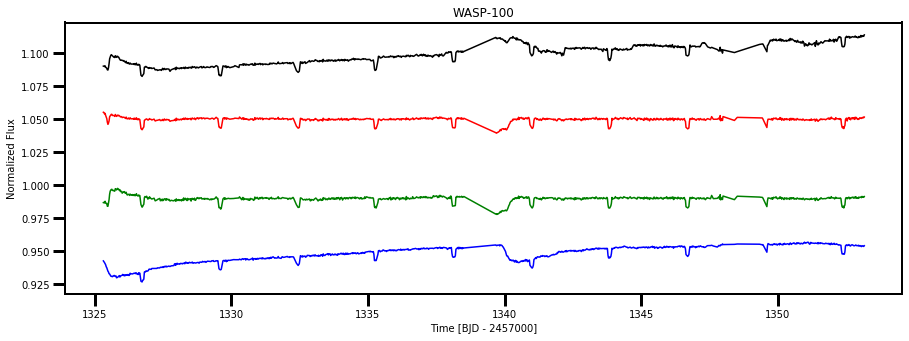

In [6]:
plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.1, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.05, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]) - 0.01, 'g')
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.05, 'b')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.title('WASP-100');

There's a planet there! 

For this star, we found the postcard level 1D background did a good job at removing additional noise in the data. We can check which background model was used by calling:

In [7]:
data.bkg_type

'PC_LEVEL'

We can even plot the background as a function of time to see what was removed from our light curve. All three background models are saved and can be called by the following:
    - 1D postcard background : data.bkg_type = 'PC_LEVEL' : keyword = data.flux_bkg
    - 1D TPF background : data.bkg_type = 'TPF_LEVEL' : keyword = data.tpf_flux_bkg
    - 2D TPF backround : data.bkg_type = 'TPF_2D_LEVEL' : keyword = data.bkg_tpf

AttributeError: 'TargetData' object has no attribute 'tpf_flux_bkg'

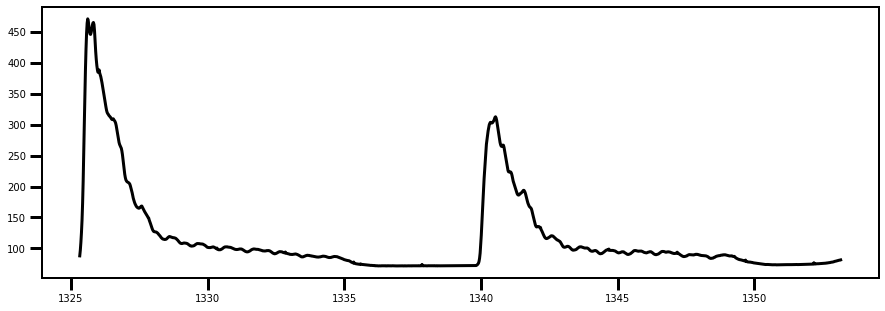

In [8]:
plt.figure(figsize=(15,5))

plt.plot(data.time, data.flux_bkg, 'k', label='1D postcard', linewidth=3)
plt.plot(data.time, data.tpf_flux_bkg, 'r--', label='1D TPF', linewidth=2)
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.legend();

And to see what a frame of the 2D background looks like, we can plot it as

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.bkg_tpf[0])
ax2.set_title('2D interpolated background');

What does our automatically chosen aperture look like? And how does it compare to where the star falls on the TPF?

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.aperture)
ax2.set_title('Aperture');

Let's save these data to a FITS file so we have them later. By default, this will be saved to a `~/.eleanor` directory, but that can be changed by setting a `directory`.

In [ ]:
data.save()

#### 1.2 Custom Apertures

That was easy! But what if you're not satisfied with $\texttt{eleanor}$'s default choice of aperture? Well, we provide you with three ways to explore different apertures.

(1) All of the apertures $\texttt{eleanor}$ tries behind the scenes are saved! And so are their raw and corrected light curves. We can explore these options by calling

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.all_apertures[16], cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')

ax2.plot(data.time[q], data.all_raw_flux[16][q]/np.nanmedian(data.all_raw_flux[16][q]), 'k', label='Raw')
ax2.plot(data.time[q], data.all_corr_flux[16][q]/np.nanmedian(data.all_corr_flux[16][q]) - 0.03, 'r', label='Corrected')
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux')
ax2.legend();

(2) $\texttt{eleanor}$ can help we create your own mask. By calling `eleanor.custom_aperture()`, we can choose from a circular or rectangular aperture. We can also choose the size (radius or length x width) and the pixel the aperture is centered on by passing in a list of $\textit{(x,y)}$ to `pos`. The aperture will only be created on pixels within the TPF (it won't spill over to other pixels). Calling `eleanor.custom_aperture()` overwrites `eleanor.TargetData.aperture`, `eleanor.TargetData.raw_flux`, and `eleanor.TargetData.corr_flux`.

In [ ]:
eleanor.TargetData.custom_aperture(data, shape='circle', r=2, pos=[7,6], method='exact')
eleanor.TargetData.get_lightcurve(data)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax2.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q]), 'k', label='Raw')
ax2.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) - 0.035, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

(3) We can pass in our own mask by creating a 2D array of the same shape as the TPF and calling `eleanor.TargetData.get_lightcurve(aperture=mask)`

In [ ]:
mask = np.zeros(np.shape(data.tpf[0]))
mask[6:8,6:8] = 1
data.get_lightcurve(aperture=mask)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(mask, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax2.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q]), 'k', label='Raw')
ax2.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) - 0.035, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

With one line of code, we can pass this through as a [lightkurve](https://github.com/KeplerGO/lightkurve) object and begin using the functionality of that package. 

In [ ]:
lk = data.to_lightkurve()
lk.plot()

##### 1.2.1 Vetting your light curve at the pixel level

We have created a user-friendly method to analyzing your light curve at the pixel level to look for any odd features that might affect only a few pixels.

In [ ]:
vis = eleanor.Visualize(data)
vis.pixel_by_pixel(rowrange=[5,11], colrange=[5,11])

This function call produces a light curve for every pixel, plotted in the same orientation as the TPF cutout requested. Here, we can see the transit events appear to fall on the central pixels, where the star is brightest. This might be a real planet, on the star we think it is on!

#### 1.3 Systematics Corrections

When we called eleanor.TargetData() in 1.1, some simple systematics corrections were automatically performed on the light curve. Let's apply those explicitly to the newly created raw light curve from the custom aperture.

In [ ]:
corr_flux = eleanor.TargetData.corrected_flux(data, flux=data.raw_flux)

In [ ]:
plt.plot(data.time[q], corr_flux[q], 'k.')

plt.ylabel('Flux')
plt.xlabel('Time')

We can then run pca with this flux time series to remove any shared systematics with nearby stars.

In [ ]:
data.corrected_flux(flux=corr_flux, modes=4, pca=True)

In [ ]:
plt.plot(data.time[q], data.pca_flux[q], 'k.')
plt.ylabel('Flux')
plt.xlabel('Time')

PSF modeling is always an option too!

In [ ]:
eleanor.TargetData.psf_lightcurve(data, model='gaussian')

In [ ]:
lk = LC(data.time[q], data.psf_flux[q]).plot()

We also could have used a Moffat profile, or passed through our own data or uncertainty array. There is quite a bit of flexibility in how the PSF models are fit, as described in the docs.

#### 1.4 Stars Observed in Multiple Sectors

$\texttt{eleanor}$ has some built-in tools to make it easier to work with stars that are observed in multiple TESS sectors. Let's consider WASP-100 again, which was observed in both Sectors 1 and 2. When we previously called `eleanor.Source()`, we can instead call `eleanor.multi_sectors()`, which will make a list of Source objects for all sectors requested.

In [ ]:
star = eleanor.multi_sectors(tic=38846515, sectors=[1,2], tc=True)

In this case, I only wanted sectors 1 and 2. However, I could have passed through `sectors=all` to get all sectors in which this star was observed.

In [ ]:
print(star)

Yep, it's a list of objects!
We can then call `eleanor.TargetData()` on each.

In [ ]:
data0 = eleanor.TargetData(star[0], height=15, width=15, bkg_size=31, do_psf=False, do_pca=False)
data1 = eleanor.TargetData(star[1], height=15, width=15, bkg_size=31, do_psf=False, do_pca=False)

q0 = data0.quality == 0
q1 = data1.quality == 0

plt.plot(data0.time[q0], data0.corr_flux[q0]/np.median(data0.corr_flux[q0]), 'k.')
plt.plot(data1.time[q1], data1.corr_flux[q1]/np.median(data1.corr_flux[q1]), 'r.')

plt.ylabel('Normalized Flux')
plt.xlabel('Time')

plt.show()

If you are only interested in one Sector your star was observed in, you can call `eleanor.Source(sector=1)` and specify the Sector you are interested in. If your star was observed in multiple sectors and you call `eleanor.Source()`, it will return the light curve from the most recent Sector the star was observed in.

#### 1.5 Good practices

We're still exploring what the best practices are generally. Good practices seem to differ across the detector, but here's what we believe so far. If you discover anything that works well for you, we and other $\texttt{eleanor}$ users would surely love to know them!

Good background subtraction is very important. The size of the region to use for an "ideal" background changes across the detector. Generally, bigger is better, we typically recommend using a region larger than the standard TPF. Currently, the background used must be a rectangle centered on the star, with size `bkg_size`

PSF modeling (`do_psf=True`) seems to work very well for relatively bright, isolated stars. Presently the only PSF model is a Gaussian, but both Gaussian and Poisson likelihood functions are possible. Do note that this requires tensorflow. Note that PSF modeling is very much in beta and our current implementation has known issues for very faint stars (fainter than I ~ 15, generally).

If you find anything that works well for your science, or uncover any issues, please let us know! Github [issues](https://github.com/afeinstein20/eleanor/issues) or [pull requests](https://github.com/afeinstein20/eleanor/pulls) are welcomed.